# Generate mosaic data for training

In [ ]:
import os
import numpy as np
import cv2
from skimage import img_as_ubyte, img_as_float
from tqdm import tqdm
from natsort import natsorted
import glob

# INPUT PARAMETERS
INPUT_EXTENSIONS = ["*.jpg", "*.png"]
trainingIN = 'D:\\NN test\\trainingIN\\'
trainingOUT = 'D:\\NN test\\trainingOUT\\'
trainingMosaicIN = 'D:\\NN test\\mosaicTrainingIN\\'
trainingMosaicOUT = 'D:\\NN test\\mosaicTrainingOUT\\'
size_mosaic = 256

# Create directories if they don't exist
if not os.path.exists(trainingMosaicIN):
    os.makedirs(trainingMosaicIN)

if not os.path.exists(trainingMosaicOUT):
    os.makedirs(trainingMosaicOUT)

# Function to get files based on multiple extensions
def get_files_from_dir(directory, extensions):
    files = []
    for ext in extensions:
        files.extend(glob.glob(os.path.join(directory, ext)))
    return natsorted(files)

# Function to process the image
def process_image(image):
    size_processed = max((image.shape[0] // size_mosaic + 1) * size_mosaic, 
                         (image.shape[1] // size_mosaic + 1) * size_mosaic)
    processed_image = np.zeros((size_processed, size_processed) + image.shape[2:])
    processed_image[:image.shape[0], :image.shape[1]] = image
    return processed_image

# Convert grayscale image to RGB
def to_rgb(image):
    if len(image.shape) == 2:  # If the image is grayscale
        return cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return image

# Load images
base_filenames_in = get_files_from_dir(trainingIN, INPUT_EXTENSIONS)
base_filenames_out = get_files_from_dir(trainingOUT, INPUT_EXTENSIONS)

kk = 1
for file_in, file_out in tqdm(zip(base_filenames_in, base_filenames_out), total=len(base_filenames_in)):
    # Load the images (supports both RGB and grayscale)
    image_in = cv2.imread(file_in, cv2.IMREAD_UNCHANGED)
    image_out = cv2.imread(file_out, cv2.IMREAD_UNCHANGED)

    # Convert images to RGB
    image_in = to_rgb(image_in)
    image_out = to_rgb(image_out)

    # Convert to float
    image_in1 = img_as_float(image_in)
    image_in2 = img_as_float(image_out)

    # Process the image (zero padding, etc.)
    image1 = process_image(image_in1)
    image2 = process_image(image_in2)
    
    num_mosaic = image1.shape[0] // size_mosaic

    for ii in range(num_mosaic):
        for jj in range(num_mosaic):
            sub_image1 = image1[ii*size_mosaic:(ii+1)*size_mosaic, jj*size_mosaic:(jj+1)*size_mosaic]
            sub_image2 = image2[ii*size_mosaic:(ii+1)*size_mosaic, jj*size_mosaic:(jj+1)*size_mosaic]

            angle = np.random.choice([0, 90, 180, 270])
            rows, cols = sub_image1.shape[:2]
            M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
            sub_image1 = img_as_float(cv2.warpAffine(sub_image1, M, (cols, rows)))
            sub_image2 = img_as_float(cv2.warpAffine(sub_image2, M, (cols, rows)))

            if np.random.randint(0, 2):  # Random flip
                sub_image1 = np.fliplr(sub_image1)
                sub_image2 = np.fliplr(sub_image2)

            # Check if both sub-images are not empty
            if not (np.all(sub_image1 == 0) and np.all(sub_image2 == 0)):
                cv2.imwrite(os.path.join(trainingMosaicIN, f"{kk}.png"), img_as_ubyte(sub_image1))
                cv2.imwrite(os.path.join(trainingMosaicOUT, f"{kk}.png"), img_as_ubyte(sub_image2))
                kk += 1

# U-Net Training

### Import & check GPU & check Path with training images

In [12]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [13]:
#Check GPU
torch.cuda.get_device_name(0)

'NVIDIA TITAN RTX'

In [19]:
#Input for network training
path_lr1 = pathlib.Path('D:\\NN test\\mosaicTrainingIN\\')
print('Number of input training images:', len(os.listdir(path_lr1)))

#Output for network training
path_hr1 = pathlib.Path('D:\\NN test\\mosaicTrainingOUT\\')
print('Number of ioutput training images:', len(os.listdir(path_hr1)))

Number of input training images: 48624
Number of ioutput training images: 48624


### Model & Batch size

In [7]:
bs,size = 32,256
arch = models.resnet34

### Additionally transform data

In [8]:
src = ImageImageList.from_folder(path_lr1).split_by_rand_pct(0.1, seed=42)

In [9]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr1/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [10]:
data_gen = get_data(bs,size)

C:\Users\sysgen\.conda\envs\fastai1\lib\site-packages\fastai\vision\transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:760.)
  return _solve_func(B,A)[0][:,0]


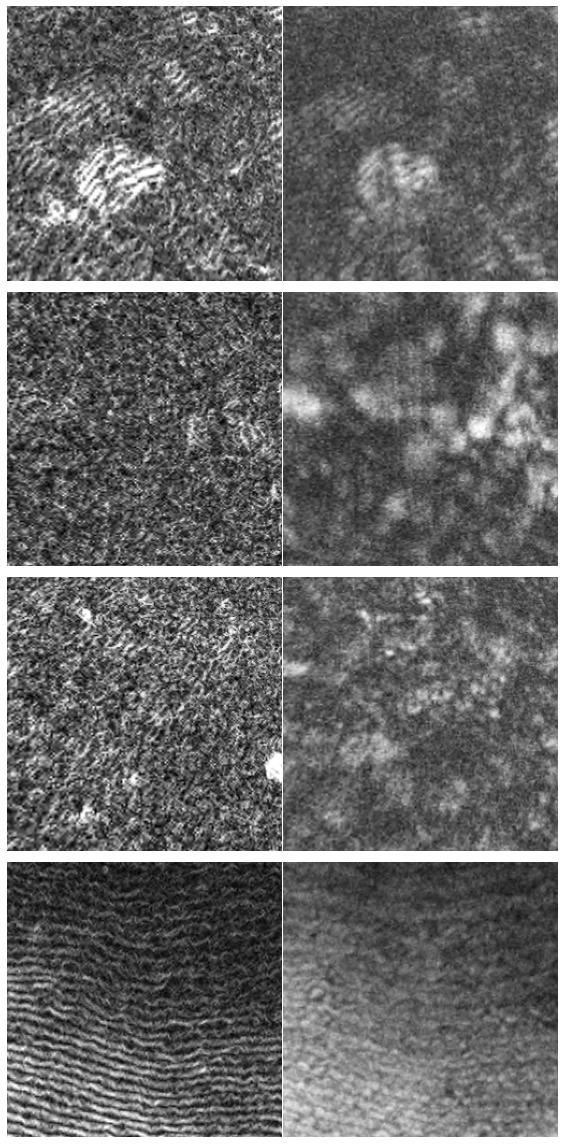

In [10]:
data_gen.show_batch(4)

### Create Learner

In [12]:
wd = 1e-3

In [13]:
y_range = (-3.,3.)

In [14]:
loss_gen = MSELossFlat()

In [15]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [16]:
learn_gen = create_gen_learner()

C:\Users\sysgen\.conda\envs\fastai1\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [17]:
learn_gen.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
__________________________________________________

### Learning

In [16]:
learn_gen.unfreeze()

In [17]:
learn_gen.fit_one_cycle(40, pct_start=0.8)

### Additional training (optional)

In [ ]:
#learn_gen.lr_find()

In [ ]:
#learn_gen.unfreeze()

In [ ]:
#learn_gen.fit_one_cycle(5, slice(2e-5,wd/5))

### Curves

In [45]:
curve = learn_gen.recorder.plot(return_fig=True)

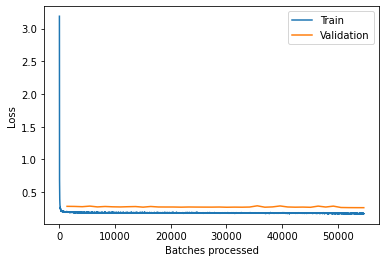

In [58]:
curve2 = learn_gen.recorder.plot_losses(return_fig=True)

### Save learning rate plot 

In [43]:
import csv

# Get the Axes object
ax = curve.axes[0]     

# Get the Line2D objects (the plotted lines) from the Axes
lines = ax.lines

# Loop through the lines and extract the data
for line in lines:
    x_data = line.get_xdata()
    y_data = line.get_ydata()
    print("x_data:", x_data)
    print("y_data:", y_data)

# Create a list of tuples with the x and y values
data = list(zip(x_data, y_data))

with open('D:/NN test/recorderPlot.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Optionally, you can write a header row
    writer.writerow(['x_data', 'y_data'])

    # Write the data rows
    writer.writerows(data)

x_data: [1.200004e-04 1.200004e-04 1.200005e-04 1.200006e-04 ... 1.701334e-08 1.596116e-08 1.503276e-08 1.422815e-08]
y_data: [1.067157 1.036102 0.99019  0.949125 ... 0.171085 0.171121 0.170682 0.17058 ]


### Save loss plots (training + validation) 

In [57]:
import csv

# Get the Axes object
ax = curve2.axes[0]          

# Get the Line2D objects (the plotted lines) from the Axes
lines = ax.lines

# Extract the data from the lines
data = []
for line in lines:
    x_data = line.get_xdata()
    y_data = line.get_ydata()
    data.append(list(zip(x_data, y_data)))

# Save the data to a CSV file
with open('D:/NN test/recorderPlotLosses3.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write a header row
    writer.writerow(['x_data_plot1', 'y_data_plot1', 'x_data_plot2', 'y_data_plot2'])

    # Write the data rows
    max_len = max(len(data[0]), len(data[1]))
    for i in range(max_len):
        row = []
        for plot_data in data:
            if i < len(plot_data):
                row.extend(plot_data[i])
            else:
                row.extend([None, None])
        writer.writerow(row)

### Show results

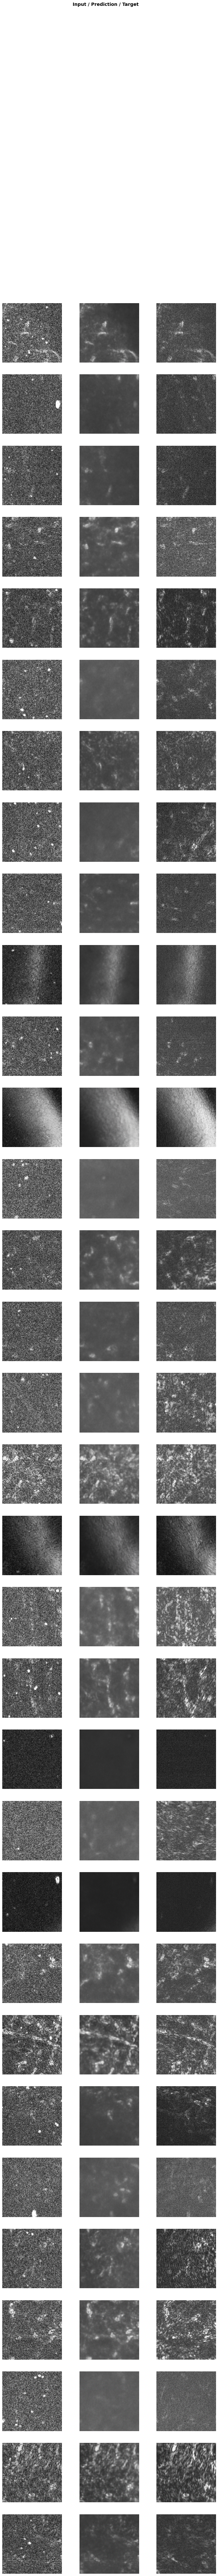

In [24]:
learn_gen.show_results(rows=100)

### Save model

In [16]:
learn_gen.path = pathlib.Path('D:/NN test/Models/Unet')

In [19]:
learn_gen.export('weights_Unet')

In [20]:
learn_gen.save('weights_Unet')

# U-Net Inference

### Network should be initialized beforehand (Model & Batch size & Create Learner)

### Load model

In [18]:
learn_gen.path = pathlib.Path('D:/NN test/Models/Unet')

In [19]:
learn_gen.load('weights_Unet')

Learner(data=ImageDataBunch;

Train: LabelList (940 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: D:\Slava\axial OTT NN\5valuesAVERAGE\train3\IN;

Valid: LabelList (104 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: D:\Slava\axial OTT NN\5valuesAVERAGE\train3\IN;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1

### Supporting sub-functions:

In [20]:
def setup_fetch_and_convert(input_directory):
    """
    Create mosaicIN, mosaicOUT, and OUT directories near the given input_directory, 
    fetch all .png and .jpg files, and convert these images to grayscale Uint8.

    Args:
        input_directory (str): The path to the input directory.

    Returns:
        tuple: A tuple containing the paths to the mosaicIN, mosaicOUT, OUT directories, and a list of .png and .jpg files.
    """
    
    # Get the base path (parent directory) of directoryIn
    base_path = os.path.dirname(os.path.dirname(input_directory))

    directoryMosaicIn = os.path.join(base_path, 'mosaicIN\\')
    directoryMosaicOut = os.path.join(base_path, 'mosaicOUT\\')
    directoryOut = os.path.join(base_path, 'OUT\\')
    
    # Inner function to create a directory if it doesn't exist
    def create_directory_if_not_exists(directory):
        if not os.path.exists(directory):
            os.makedirs(directory)

    # Ensure all directories exist
    create_directory_if_not_exists(directoryMosaicIn)
    create_directory_if_not_exists(directoryMosaicOut)
    create_directory_if_not_exists(directoryOut)
    
    # Get all .png and .jpg files in directoryIn and its subdirectories
    image_extensions = (".png", ".jpg", ".jpeg", ".tif", ".tiff")
    baseFileNamesIn = [os.path.join(root, name)
                       for root, dirs, files in os.walk(input_directory)
                       for name in files
                       if name.lower().endswith(image_extensions)]
    
    # Convert images to grayscale Uint8
    for image_path in baseFileNamesIn:
        # Read the image using skimage
        image = io.imread(image_path)

        # If the image has 3 dimensions (meaning it's RGB), convert it to grayscale
        if image.ndim == 3:
            grayscale_image = color.rgb2gray(image)
        else:
            grayscale_image = image  # Image is already grayscale

        # Convert to Uint8
        uint8_image = img_as_ubyte(grayscale_image)

        # Save the image back using skimage
        io.imsave(image_path, uint8_image)
    
    return directoryMosaicIn, directoryMosaicOut, directoryOut, baseFileNamesIn

         
def clean_directory(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                os.rmdir(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")
         
        
def display_results(image1, image2):
    """
    Display two images side by side with titles above each.

    Args:
        image_path1 (str): Path to the first image.
        image_path2 (str): Path to the second image.
    """

    # Create a new figure
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display images side by side
    ax[0].imshow(image1, cmap='gray')
    ax[0].set_title('Input')
    ax[0].axis('off')

    ax[1].imshow(image2, cmap='gray')
    ax[1].set_title('Output')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()
    
    
def reshape_and_pad(imageIn1, mosaicSize, numOverlap):
    """
    Convert an image into a padded image suitable for mosaicking.

    Args:
        imageIn1 (np.array): 2D numpy array of the input image.
        mosaicSize (int): Desired size of the mosaic.
        numOverlap (int): Number of overlapping mosaics.

    Returns:
        np.array: A padded image suitable for mosaicking.
    """

    # Convert image to square shape
    squareSize = max(imageIn1.shape)
    squareImage = np.zeros((squareSize, squareSize))
    squareImage[:imageIn1.shape[0], :imageIn1.shape[1]] = imageIn1

    # Pad image so that mosaicSize becomes its factor (for mosaicking) 
    paddedSize0 = int(np.ceil(squareSize/mosaicSize)*mosaicSize)
    paddedImage0 = np.zeros((paddedSize0, paddedSize0))
    paddedImage0[:squareSize, :squareSize] = squareImage

    # Pad image with additional borders
    step = mosaicSize//numOverlap
    paddedSize = paddedSize0 + numOverlap*step
    paddedImage = np.zeros((paddedSize, paddedSize))
    paddedImage[(numOverlap//2)*step:(numOverlap//2)*step + paddedSize0, (numOverlap//2)*step:(numOverlap//2)*step+paddedSize0] = paddedImage0

    # Additionally pad the image 
    # 1) to add edge borders,
    # 2) so that step = mosaicSize/num_overlap becomes its factor (for mosaicking)
    paddedSize2 = paddedSize + numOverlap*step
    paddedImage2 = np.zeros((paddedSize2, paddedSize2))
    paddedImage2[(numOverlap//2)*step:(numOverlap//2)*step + paddedSize, (numOverlap//2)*step:(numOverlap//2)*step+paddedSize] = paddedImage

    paddedSize3 = int(np.ceil(paddedSize2/step)*step)
    paddedImage3 = np.zeros((paddedSize3, paddedSize3))
    paddedImage3[:paddedSize2, :paddedSize2] = paddedImage2
    
    return paddedImage3, paddedSize


def crop_image_to_initial_size(img, mosaicSize, numOverlap, initial_shape):
    """
    Crop the image to its initial size.

    Args:
        img (numpy.ndarray): The image to crop.
        mosaicSize (int): Mosaic size parameter.
        numOverlap (int): Number of overlaps.
        initial_shape (tuple): Shape of the initial image (height, width).

    Returns:
        numpy.ndarray: Cropped image.
    """
    
    # Calculate step size
    step = mosaicSize // numOverlap
    
    # Determine starting and ending rows and columns for cropping
    start_row = numOverlap * step
    end_row = start_row + initial_shape[0]
    start_col = numOverlap * step
    end_col = start_col + initial_shape[1]

    # Crop the image
    img_cropped = img[start_row:end_row, start_col:end_col]
    
    return img_cropped


### Function: Inference

In [77]:
def NNprocessing(PATH_IN, model, PATH_OUT): 
    """
    Processes images using a given model and saves the output to a specified directory.
    
    Parameters:
    - PATH_IN (str): Directory containing input images.
    - model (object): Model used for prediction.
    - PATH_OUT (str): Directory to save processed images.
    
    Returns:
    None. Processed images are saved to the specified directory.
    """
    
    def numericalSort(value):
        """
        Helper function to sort strings containing numbers in a human-readable way (e.g. 10 comes after 9).
        """
        numbers = re.compile(r'(\d+)')
        parts = numbers.split(value)
        parts[1::2] = map(int, parts[1::2])
        return parts
    
    min_global = 1000;
    max_global = -1000;
    
    # Fetch sorted file paths
    file_paths = sorted(glob.glob(PATH_IN + '*.png'), key=numericalSort)
    
    for idx, infile in enumerate(tqdm(file_paths, desc="Network processing")):
        with ImagePIL.open(infile) as im:
            
            # Convert image to tensor
            pic = pil2tensor(im, np.float32)
            pic_normalized = torch.div(pic, 255.0)
            
            # Process image using the model
            inf = model.predict(Image(pic_normalized))

            # Convert prediction to numpy and adjust dimensions
            prediction_numpy = inf[2].numpy()[0, :, :]

            # Track global min and max values
            min_value = np.amin(prediction_numpy)
            max_value = np.amax(prediction_numpy)
            min_global = min(min_value, min_global)
            max_global = max(max_value, max_global)

            # Convert numpy prediction to PIL Image and save
            output_image = (255 * (prediction_numpy - min_global) / (max_global - min_global)).astype(np.uint8)
            im_output = PIL.Image.fromarray(output_image)
            im_output.save(f"{PATH_OUT}{idx}.png")

### Function: generate mosaic before inference

In [78]:
def generate_mosaic_images(imageIn, paddedSize, mosaicSize, numOverlap):
    """
    Generates mosaic images from the input image.
    
    Parameters:
    - imageIn (numpy.ndarray): Input image.
    - paddedSize (int): Size of the padded image.
    - mosaicSize (int): Size of the individual mosaics.
    - numOverlap (int): Number of overlapping mosaics.
    
    Returns:
    None. Mosaic images are saved to the specified directory.
    """
        
    step = mosaicSize//numOverlap

    # Prepare a stack to hold sections of the image
    stack = np.zeros((paddedSize, paddedSize, numOverlap*numOverlap))
    
    # Split the image into multiple sections and store in the stack
    k = 0
    for i in range(numOverlap):
        for j in range(numOverlap):
            stack[:,:,k] = imageIn[i*step : paddedSize+i*step , j*step : paddedSize+j*step]
            k += 1
    
    # Create mosaics from the stack
    mosaic = []
    numMosaic = paddedSize // mosaicSize
    for k in range(numOverlap*numOverlap):
        mosaic.append(skimage.util.view_as_blocks(stack[:,:,k], (mosaicSize, mosaicSize)))
    
    # Save mosaics in the folder
    n = 0
    total_iterations = numOverlap * numOverlap
    for k in tqdm(range(total_iterations), desc="Generating mosaics"):
        for ii in range(numMosaic):  # number of mosaic images
            for jj in range(numMosaic):
                img = mosaic[k][ii, jj, :, :]
                img = img / 255
                img_ubyte = img_as_ubyte(img)
                rgbMosaic = np.stack((img_ubyte, img_ubyte, img_ubyte), axis=2)
                skimage.io.imsave(os.path.join(directoryMosaicIn, f'{n}.png'), rgbMosaic)
                n += 1

### Function: merge mosaic after inference

In [79]:
def merge_mosaic_images(directoryMosaicOut, directoryOut, paddedSize, paddedSize3, mosaicSize, numOverlap, use_unsharp_filter, strength_unsharp_filter):
    """
    Merge the mosaic images back into their full representations.
    
    Parameters:
    - directoryMosaicOut (str): The directory where the processed mosaic images are stored.
    - directoryOut (str): The directory where the final merged image should be saved.
    - paddedSize (int): The size of the image after reshaping and padding to ensure it fits the mosaic size.
    - paddedSize3 (int): The size of the reshaped and padded image that will be the final output size.
    - mosaicSize (int): The size of each individual mosaic or sub-image.
    - numOverlap (int): Number of overlaps for the mosaics. It indicates how many times an image part will be processed as part of different mosaics.
    - use_unsharp_filter (bool): A flag to indicate if unsharp filter should be applied.
    - strength_unsharp_filter (float): The strength of the unsharp filter if applied.
    
    Returns:
    - im (numpy.ndarray): Merged mosaic image.
    """
    
    def read_images_from_directory(directory, extension='.png'):
        """
        Helper function to read and sort image files from a directory.
        """
        filenames = natsorted([f for f in os.listdir(directory) if f.endswith(extension)])
        images = []
        for fname in filenames:
            path = os.path.join(directory, fname)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            images.append(img)
        return np.stack(images, axis=-1)
    
    step = mosaicSize//numOverlap
    numMosaic = paddedSize // mosaicSize
    
    # Read images
    imageIn = read_images_from_directory(directoryMosaicOut)
    
    # Fill mosaics into the stack
    mosaicOut = np.empty((numOverlap*numOverlap, numMosaic, numMosaic), dtype=object)
    for k in tqdm(range(numOverlap * numOverlap), desc="Merging mosaics"):
        for ii in range(numMosaic):
            for jj in range(numMosaic):
                n = numMosaic*numMosaic*k + numMosaic*ii + jj
                mosaicOut[k, ii, jj] = imageIn[:,:,n]

    # Reconstruct images from mosaics
    imageOut = np.zeros((mosaicSize*numMosaic, mosaicSize*numMosaic, numOverlap*numOverlap))
    for k in range(numOverlap*numOverlap):
        imageOut[:,:,k] = np.block([[mosaicOut[k, ii, jj] for jj in range(numMosaic)] for ii in range(numMosaic)])

    # Apply unsharp filter if needed
    if use_unsharp_filter==True:
        imageOut_sharp = np.zeros((mosaicSize*numMosaic, mosaicSize*numMosaic, numOverlap*numOverlap))
        for k in range(numOverlap*numOverlap):
            # Convert the image to floating point format between 0 and 1
            image_float = imageOut[:,:,k] / 255.0
            # Apply unsharp mask
            sharpened = filters.unsharp_mask(image_float, radius=1.0, amount=strength_unsharp_filter)   #Set the Mask strength
            # Scale the image back to the range of np.uint8
            sharpened_scaled = np.clip(sharpened * 255, 0, 255).astype(np.uint8)
            imageOut_sharp[:,:,k] = sharpened_scaled
    else:
        imageOut_sharp = imageOut

    # Align reconstructed images
    im = np.zeros((paddedSize3, paddedSize3, numOverlap*numOverlap))
    for ii in range(numOverlap):
        for jj in range(numOverlap):
            k = numOverlap*ii + jj
            start_x, end_x = step*ii, step*ii + paddedSize
            start_y, end_y = step*jj, step*jj + paddedSize           
            im[start_x:end_x, start_y:end_y, k] = imageOut_sharp[:,:,k]

    # Remove the outlier frames (> 3 STD from the mean)
    mean_im = np.mean(im, axis=(0,1))
    outliers = np.abs(mean_im - np.mean(mean_im)) > 3 * np.std(mean_im)
    im = im[:,:,~outliers]
    
    return im

### Main inference control code

FULL images procesed:   0%|          | 0/4 [00:00<?, ?it/s]

Generating mosaics:   0%|          | 0/16 [00:00<?, ?it/s]

Network processing:   0%|          | 0/400 [00:00<?, ?it/s]

Merging mosaics:   0%|          | 0/16 [00:00<?, ?it/s]

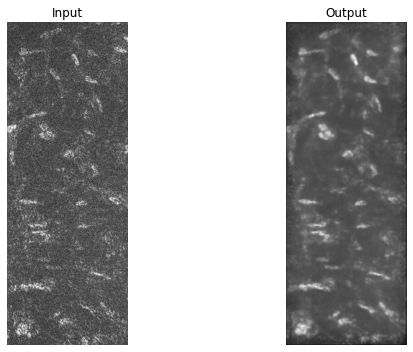

Generating mosaics:   0%|          | 0/16 [00:00<?, ?it/s]

Network processing:   0%|          | 0/576 [00:00<?, ?it/s]

Merging mosaics:   0%|          | 0/16 [00:00<?, ?it/s]

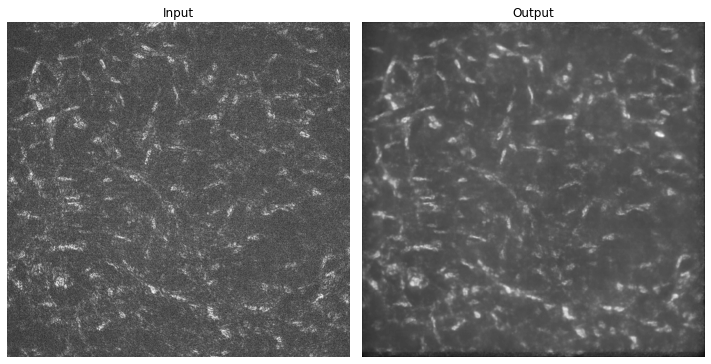

Generating mosaics:   0%|          | 0/16 [00:00<?, ?it/s]

Network processing:   0%|          | 0/400 [00:00<?, ?it/s]

Merging mosaics:   0%|          | 0/16 [00:00<?, ?it/s]

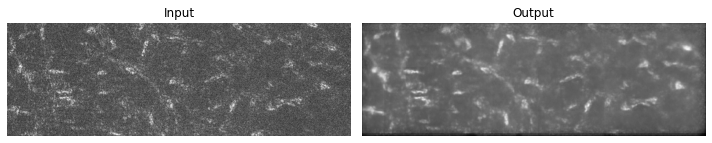

Generating mosaics:   0%|          | 0/16 [00:00<?, ?it/s]

Network processing:   0%|          | 0/256 [00:00<?, ?it/s]

Merging mosaics:   0%|          | 0/16 [00:00<?, ?it/s]

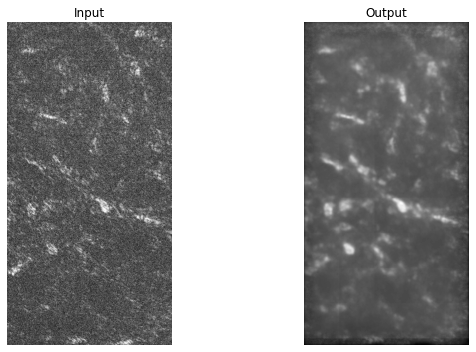

In [80]:
import glob, os
import skimage
import numpy as np
import cv2
import re
from PIL import Image as ImagePIL
from natsort import natsorted
from skimage import io, color, img_as_ubyte, filters
from tqdm.notebook import tqdm
import warnings
from skimage import exposure

# Suppress low contrast warnings
warnings.simplefilter("ignore")

################################################ 
# INPUT PARAMETERS:
directoryIn = 'D:\\NN test\\inference\\IN\\'
mosaicSize=256 # Size of mosaicked sub-image
numOverlap = 4 # num_overlap should be the factor or mosaic size (e.g. 2, 4).
                #Larger num_overlap means more overlapping mosaic sub-images, better averaging but longer inference
use_unsharp_filter = False
strength_unsharp_filter = 4.0
################################################

# Prepare folders and data for inference (.png or .jpg are acceptable)
directoryMosaicIn, directoryMosaicOut, directoryOut, baseFileNamesIn = setup_fetch_and_convert(directoryIn)

# Process all images
for fullFileNameIn in tqdm(baseFileNamesIn, desc="FULL images procesed"):
    
    # Clean the intermediate directories at the beginning of each iteration
    clean_directory(directoryMosaicIn)
    clean_directory(directoryMosaicOut)
    
    # Read image
    imageIn = skimage.io.imread(fullFileNameIn)
    
    # Prepare image for mosaicking
    full_paddedImage, mini_paddedSize = reshape_and_pad(imageIn, mosaicSize, numOverlap)
    
    # Mosaicking and NN Processing
    generate_mosaic_images(full_paddedImage, mini_paddedSize, mosaicSize, numOverlap)
    NNprocessing(directoryMosaicIn, learn_gen, directoryMosaicOut)
    im = merge_mosaic_images(directoryMosaicOut, directoryOut, mini_paddedSize, full_paddedImage.shape[0], mosaicSize, numOverlap, use_unsharp_filter, strength_unsharp_filter)

    # Average overlapping sub-images
    img = np.mean(im, axis=2) / 255.0
    
    # Crop the image to initial size
    imageOut = img_as_ubyte(crop_image_to_initial_size(img, mosaicSize, numOverlap, imageIn.shape))
   
    # Display results
    display_results(imageIn, imageOut)
    
    # Write results in directoryOut
    relPathIn = os.path.relpath(fullFileNameIn, directoryIn)
    fullFileNameOut = os.path.join(directoryOut, relPathIn)
    cv2.imwrite(fullFileNameOut, imageOut)